In [1]:
import random
import numpy as np
import torch as th
from tqdm import tqdm
from torchinfo import summary
from torch.utils.data import DataLoader, random_split

import matplotlib.pyplot as plt
from utils.plots import multiviz_trajs

from utils.load_data import load_multi_trajs_data
from utils.bernstein_coeff_order10_arbitinterval import get_coeffs
from optimizers.mlp_sf_multi_agent_varying_bounds_1 import InitModel, mlp_sf_multi_agent

In [2]:
num         = 50
t_fin       = 5
num_agent   = 16

vq_name     = "train_01"
name        = "train_01"
batch_size  = 256

num_epochs  = 500
device      = th.device("cuda" if th.cuda.is_available() else "cpu")

print(device)
th.set_float32_matmul_precision('high')

cuda


In [ ]:
P, Pdot, Pddot = get_coeffs(num, t_fin, device)
nvar = P.size(dim=-1) 

dataset, min_inp, max_inp, inp_mean, inp_std = load_multi_trajs_data(
    f"multi_trajs_{vq_name}_agents_{num_agent}.npz", num_agent=16, nvar=11
)
train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=0, drop_last=True)
min_inp.item(), max_inp.item(), inp_mean.item(), inp_std.item()

(-1.7499819993972778,
 1.749986171722412,
 0.05864451825618744,
 0.5283641219139099)

In [4]:
pcd_features, hidden_dim_mlp, out_dim_mlp = 6*nvar*num_agent, 2048, (3*nvar*num_agent)+(3*nvar*num_agent)
inp_dim_mlp = pcd_features+(3*nvar*num_agent)+6
model_sf = InitModel(18, 2048, pcd_features, inp_dim_mlp, hidden_dim_mlp, out_dim_mlp, min_inp, max_inp, inp_mean, inp_std, num_agent).to(device)
diff_opt = mlp_sf_multi_agent(P, Pdot, Pddot, batch_size, num_agent)

In [5]:
sample_size = 50
inp, state_x, state_y, state_z, c_pred, center, radii = dataset[:sample_size]

inp = inp.to(device)
state_x = state_x.to(device)
state_y = state_y.to(device)
state_z = state_z.to(device)
c_pred = c_pred.to(device)
center = center.to(device) 
radii = radii.to(device) 

diff_opt.num_batch = sample_size
diff_opt.maxiter = 100

with th.no_grad():
    c_x_pred = c_pred[:, 0: diff_opt.nvar*diff_opt.num_agent]
    c_y_pred = c_pred[:, diff_opt.nvar*diff_opt.num_agent : 2*diff_opt.nvar*diff_opt.num_agent]
    c_z_pred = c_pred[:, 2*diff_opt.nvar*diff_opt.num_agent : 3*diff_opt.nvar*diff_opt.num_agent]
    
    c_x_guess, c_y_guess, c_z_guess, lamda_x_init, lamda_y_init, lamda_z_init = model_sf(inp, th.cat([c_pred, center, radii], dim=-1))
    # c_x_guess, c_y_guess, c_z_guess, lamda_x_init, lamda_y_init, lamda_z_init = th.zeros((6, sample_size, nvar * num_agent), device=device)

    x_ell, y_ell, z_ell = center.permute(1, 0)
    x_ell, y_ell, z_ell = (
        x_ell[..., None] * th.ones((sample_size, num * num_agent), device=device),
        y_ell[..., None] * th.ones((sample_size, num * num_agent), device=device),
        z_ell[..., None] * th.ones((sample_size, num * num_agent), device=device)
    )

    a_ell, b_ell, c_ell = radii.permute(1, 0)
    a_ell, b_ell, c_ell = (
        a_ell[..., None] * th.ones((sample_size, num * num_agent), device=device),
        b_ell[..., None] * th.ones((sample_size, num * num_agent), device=device),
        c_ell[..., None] * th.ones((sample_size, num * num_agent), device=device)
    )

    primal_sol_x, primal_sol_y, primal_sol_z, accumulated_res_primal, accumulated_res_fixed_point, res_primal_stack, res_fixed_point_stack = diff_opt(c_x_pred, c_y_pred, c_z_pred, c_x_guess, c_y_guess, c_z_guess, lamda_x_init, lamda_y_init, lamda_z_init, state_x, state_y, state_z, x_ell, y_ell, z_ell, a_ell, b_ell, c_ell)

diff_opt.num_batch = batch_size
diff_opt.maxiter = 15

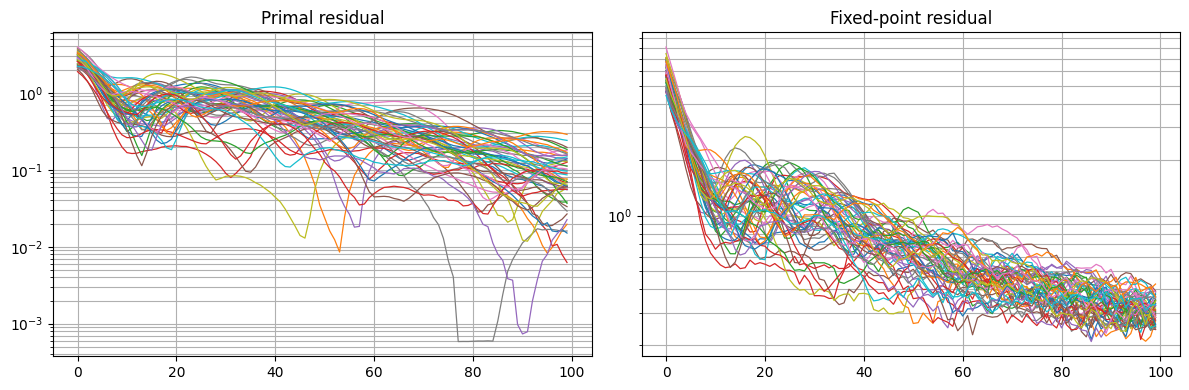

In [6]:
fig = plt.figure(figsize=(12, 4))
ax = plt.subplot(121)
ax.plot(res_primal_stack.detach().cpu().numpy(), lw=0.9)
ax.set_title("Primal residual")
ax.set_yscale('log')
ax.grid(which="both")

ax = plt.subplot(122)
ax.plot(res_fixed_point_stack.detach().cpu().numpy(), lw=0.9)
ax.set_title("Fixed-point residual")
ax.set_yscale('log')
ax.grid(which="both")

plt.tight_layout()
plt.show()

In [8]:
idx = 42 # np.random.randint(0, sample_size)  # 42, 26
print(idx)

x_traj_init, y_traj_init, z_traj_init = c_pred.reshape(-1, 3, num_agent, 11)[idx] @ diff_opt.P.mT

x_traj = primal_sol_x.reshape(-1, num_agent, 11)[idx] @ diff_opt.P.mT
y_traj = primal_sol_y.reshape(-1, num_agent, 11)[idx] @ diff_opt.P.mT
z_traj = primal_sol_z.reshape(-1, num_agent, 11)[idx] @ diff_opt.P.mT

multiviz_trajs(
    th.stack([x_traj_init, x_traj], dim=0).cpu().detach().numpy(), 
    th.stack([y_traj_init, y_traj], dim=0).cpu().detach().numpy(), 
    th.stack([z_traj_init, z_traj], dim=0).cpu().detach().numpy(), 
    nrows=1, ncols=2, height=400, width=1300, titles=["VQ-init", "SF-final"]
)

42


In [ ]:
epochs = 300
step = 0 
beta = 1.0 # 3.5

optimizer = optim.AdamW(model_sf.parameters(), lr = 2e-4, weight_decay=6e-1)
# optimizer = optim.RMSprop(model.parameters(), lr = 2e-4, weight_decay=6e-5)
# scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.1, patience=3)

avg_train_loss, avg_primal_loss, avg_fixed_point_loss, avg_fixed_proj_loss = [], [], [], []
for epoch in range(epochs):
	
	losses_train, primal_losses, fixed_point_losses, proj_losses = [], [], [], []
	model_sf.train()
	for (inp, state_x, state_y, state_z, c_pred, center, radii) in train_loader:
		
		inp = inp.to(device)
		state_x = state_x.to(device)
		state_y = state_y.to(device)
		state_z = state_z.to(device)
		c_pred = c_pred.to(device)
		center = center.to(device) 
		radii = radii.to(device) 

		c_x_pred = c_pred[:, 0: diff_opt.nvar*diff_opt.num_agent]
		c_y_pred = c_pred[:, diff_opt.nvar*diff_opt.num_agent : 2*diff_opt.nvar*diff_opt.num_agent]
		c_z_pred = c_pred[:, 2*diff_opt.nvar*diff_opt.num_agent : 3*diff_opt.nvar*diff_opt.num_agent]
		
		c_x_guess, c_y_guess, c_z_guess, lamda_x_init, lamda_y_init, lamda_z_init = model_sf(inp, th.cat([c_pred, center, radii], dim=-1))

		x_ell, y_ell, z_ell = center.permute(1, 0)
		x_ell, y_ell, z_ell = (
			x_ell[..., None] * th.ones((batch_size, num * num_agent), device=device),
			y_ell[..., None] * th.ones((batch_size, num * num_agent), device=device),
			z_ell[..., None] * th.ones((batch_size, num * num_agent), device=device)
		)

		a_ell, b_ell, c_ell = radii.permute(1, 0)
		a_ell, b_ell, c_ell = (
			a_ell[..., None] * th.ones((batch_size, num * num_agent), device=device),
			b_ell[..., None] * th.ones((batch_size, num * num_agent), device=device),
			c_ell[..., None] * th.ones((batch_size, num * num_agent), device=device)
		)

		primal_sol_x, primal_sol_y, primal_sol_z, accumulated_res_primal, accumulated_res_fixed_point, res_primal_stack, res_fixed_point_stack = diff_opt(c_x_pred, c_y_pred, c_z_pred, c_x_guess, c_y_guess, c_z_guess, lamda_x_init, lamda_y_init, lamda_z_init, state_x, state_y, state_z, x_ell, y_ell, z_ell, a_ell, b_ell, c_ell)
		loss, fixed_point_loss, primal_loss, proj_loss  = model_sf.mlp_loss(accumulated_res_primal, accumulated_res_fixed_point, primal_sol_x, primal_sol_y, primal_sol_z, c_pred)
	
		optimizer.zero_grad()
		loss.backward()
		optimizer.step()
		
		losses_train.append(loss.detach().cpu().numpy()) 
		proj_losses.append(proj_loss.detach().cpu().numpy())
		primal_losses.append(primal_loss.detach().cpu().numpy())
		fixed_point_losses.append(fixed_point_loss.detach().cpu().numpy())
		
		
	if epoch % 4 == 0:    
		print(f"Epoch: {epoch + 1}, Train Loss: {np.average(losses_train):.3f}, primal_loss: {np.average(primal_losses):.3f}, fixed_point_loss: {np.average(fixed_point_losses):.3f} ")

	step += 0.15 #0.15
	# scheduler.step(np.average(losses_train))
	avg_train_loss.append(np.average(losses_train)), avg_primal_loss.append(np.average(primal_losses)), avg_fixed_point_loss.append(np.average(fixed_point_losses)), avg_fixed_proj_loss.append(np.average(primal_losses))
	
	
